In [57]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # To see Progress

REBUILD_DATA = False  #Only Rebuild first time (preprocess data first time)

class HappyOrSad():
    IMG_SIZE = 50   #Change size to 50X50

    HAPPY = "FaceExpression/happy"
    SAD = "FaceExpression/sad"

    LABELS = {HAPPY: 0,SAD: 1}

    training_data = []

    happyCount = 0
    sadCount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])

                    if label==self.SAD:
                        self.sadCount +=1
                    elif label == self.HAPPY:
                        self.happyCount+=1
                except Exception as e:
                    # pass
                    print(e)
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("SAD  : ",self.sadCount)
        print("HAPPY  : ",self.happyCount)


if REBUILD_DATA:
    happyorsad = HappyOrSad()
    happyorsad.make_training_data()       

training_data = np.load("training_data.npy",allow_pickle=True)
print(len(training_data))

305


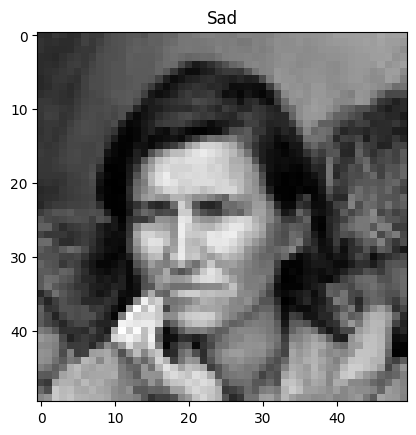

In [58]:
import matplotlib.pyplot as plt
img_num = 1
plt.imshow(training_data[img_num][0],cmap="gray")
# Add label in plot (0 for happy and 1 for sad)
if np.where(training_data[img_num][1]==1)[0][0]==0:
    plt.title("Happy")
elif np.where(training_data[img_num][1]==1)[0][0]==1:
    plt.title("Sad")

plt.show()


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1,32,5) # 1 input image channel, 32 output channels, 5x5 square convolution kernel
        self.conv2 = nn.Conv2d(32,64,5) # 32 input image channel, 64 output channels, 5x5 square convolution kernel
        self.conv3 = nn.Conv2d(64,128,5) # 64 input image channel, 128 output channels, 5x5 square convolution kernel
        x = torch.randn(50,50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear,512) #  input features, 512 output features
        self.fc2 = nn.Linear(512,2) # 512 input features, 2 output features
    
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2)) # Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2)) # Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2)) # Max pooling over a (2,2) window

        # print(x[0].shape)
        if self._to_linear is None:
            sh = x[0].shape
            self._to_linear = sh[0]*sh[1]*sh[2]
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1) # activation function

net = Net()
    
    

In [60]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function= nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X / 255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 #VALIDATION DATA Percentage
val_size = int(len(X)*VAL_PCT)
print(val_size)

30


In [61]:
train_X = X[:-val_size] 
train_y = y[:-val_size] 

test_X = X[-val_size:] 
test_y = y[-val_size:] 

print(len(train_X))
print(len(test_X))

275
30


In [63]:
BATCH_SIZE = 10
EPOCHS=1 

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
        # print(i,i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        # print(batch_X)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        optimizer.zero_grad() #Same as net.zero_grad() because we have passed net.parameters() in optimizer
        outputs = net(batch_X)
        
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
print(loss)



100%|██████████| 28/28 [00:00<00:00, 32.29it/s]

tensor(0.1193, grad_fn=<MseLossBackward0>)


In [65]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct+=1
        total+=1

print("Accuracy : ",round(correct/total,3))


# Remove last commit 
# git reset --hard HEAD~1

100%|██████████| 30/30 [00:00<00:00, 416.86it/s]

Accuracy :  0.8
